### Topic Modeling: Demand for Cybersecurity Professionals  

In [3]:
import pandas as pd 
import numpy as np
import nltk 
from nltk.corpus import stopwords 
import re
import string
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#### Data Preprocessing 
Indeed Data 

In [4]:
df = pd.read_csv("/Users/somasunder_gss/Documents/GitHub/Scape-Save-DAEN690/Datasets/indeed_cleaned.csv.gz")

In [5]:
#Remove duplicate postings if the job title, description and location are the same 
df.drop_duplicates(subset=['job_title', 'description_text', 'location'], inplace=True)

In [6]:
#Set to lower case so capitalized titles don't get counted separately
df['job_title'] = df['job_title'].apply(lambda x: str(x).lower())
#Set to lower case for job descriptions 
df['description_text'] = df['description_text'].apply(lambda x: str(x).lower())
#remove numerical values from job description
df['description_text'] = df['description_text'].str.replace('\d+', '')
#remove links from job description 
df['description_text'] = df['description_text'].str.replace('http\S+|www.\S+', '', case=False)



<ipython-input-6-dc3d54ff4ced>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['description_text'] = df['description_text'].str.replace('\d+', '')
<ipython-input-6-dc3d54ff4ced>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['description_text'] = df['description_text'].str.replace('http\S+|www.\S+', '', case=False)


In [7]:
df

,company_name,country,country_code,current_url,date_posted_parsed,description,description_text,domain,job_title,job_type,jobid,location,region,timestamp,qualifications,Unnamed: 15
0,NaN,US,UM,https://www.indeed.com/viewjob?jk=00cf07391044...,NaN,<div>\n <p>DomainTools is looking for a talent...,domaintools is looking for a talented senior a...,www.indeed.com,senior cyber security account executive (remot...,"[""Full-time""]",00cf07391044c067,Remote,NaN,12/24/2022,NaN,NaN
1,BTS Software Solutions,US,NaN,https://www.indeed.com/viewjob?dae2824b04=b80b...,NaN,<p><b>Cyber Defense Analyst III</b><br><b>REQ ...,cyber defense analyst iiireq id: -just awarded...,www.indeed.com,cyber defense analyst iii,"[""Full-time""]",395221d50cb09389,"San Antonio, TX 78251",NaN,12/24/2022,NaN,NaN
2,Change Healthcare,US,US,https://www.indeed.com/viewjob?jk=434af1ddd634...,NaN,<div>\n <p><b>Title</b><br> Senior Cybersecuri...,title senior cybersecurity incident response a...,NaN,senior cybersecurity incident response analyst,"[""Full-time""]",434af1ddd63444bf,South Carolina,NaN,07-03-2022,NaN,NaN
3,NaN,US,UM,https://www.indeed.com/viewjob?jk=1547fa2c6b50...,NaN,<div>\n <p><b>About the Team</b></p> \n <p> Jo...,about the team \n joining capco means joining...,www.indeed.com,managing principal - cybersecurity,NaN,1547fa2c6b504d38,Remote,NaN,12/24/2022,NaN,NaN
4,HALVIK,US,US,https://www.indeed.com/viewjob?jk=4770813092f5...,NaN,<div>\n <div>\n <div>\n If you are looking ...,if you are looking for a rewarding career with...,www.indeed.com,cybersecurity systems analyst,"[""Full-time""]",4770813092f57d23,"Tampa, FL",NaN,12/24/2022,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11877,Lighthouse Lab Services,US,US,https://www.indeed.com/viewjob?jk=c43bf16c68ee...,NaN,<div>\n <p>Lighthouse Lab Services is excited ...,lighthouse lab services is excited to be worki...,indeed.com,director of it management (ciso),"[""Full-time""]",c43bf16c68ee5f6a,"Atlanta, GA",NaN,7/20/2022,NaN,NaN
11879,NaN,US,US,https://www.indeed.com/viewjob?jk=8c317805cd78...,NaN,<div>\n Note: By applying to this position you...,note: by applying to this position you will ha...,NaN,"program manager, compliance, google cloud ciso","[""Full-time""]",8c317805cd7856c3,"Raleigh, NC",NaN,07-03-2022,NaN,NaN
11880,Abnormal Security,US,US,https://www.indeed.com/viewjob?jk=d55a050f564b...,2022-06-25T10:31:20.963Z,"<div>\n <h2 class=""jobSectionHeader""><b>About ...",about abnormal security \n users and companie...,NaN,head of program management - office of the ciso,NaN,d55a050f564b9d96,"Washington, DC",NaN,07-03-2022,NaN,NaN
11881,Google,US,US,https://www.indeed.com/viewjob?jk=1f951e7bd07c...,NaN,<div>\n Note: By applying to this position you...,note: by applying to this position you will ha...,NaN,"lead technical program manager, compliance ena...","[""Full-time""]",1f951e7bd07c6a1b,"Raleigh, NC",NaN,07-03-2022,NaN,NaN


In [8]:
#Create function to categorize role types 

def role_type(x):
    if 'lead' in x:
        return 'senior'
    elif 'senior' in x:
        return 'senior'
    elif 'sr' in x:
        return 'senior'
    elif 'chief' in x:
        return 'upper mgmt'
    elif 'manager' in x:
        return 'upper mgmt'
    elif 'principal' in x:
        return 'upper mgmt'
    elif 'junior' in x:
        return 'entry-level'
    elif 'jr' in x:
        return 'entry-level'
    elif 'entry-level' in x:
        return 'entry-level'
    elif 'entry level' in x:
        return 'entry-level'
    elif 'professor' in x: 
        return 'academia'
    else:
        return 'other'
    
df['role_type'] = df['job_title'].apply(role_type)

#Can be used for visualizations 
job_df = df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]


In [9]:
#Comparing job descriptions using cosine similarity will help remove job descriptions that are almost identical with additional word difference 
#Helps reduce processing time of the model 

corpus= df['description_text']

count_vect = CountVectorizer()

x_counts = count_vect.fit_transform(corpus)

cos_df = pd.DataFrame(cosine_similarity(x_counts))
 
i, j = np.indices(cos_df.shape).reshape(2, -1)

cos_values = cos_df.values.reshape(-1)

cos_sim_df = pd.DataFrame({'i': i, 'j': j, 'score':cos_values})

#similarity score >0.99 indicates that the job descriptions are very similar with slight variations in wordings
cos_rem = cos_sim_df[(cos_sim_df['score']>0.99)&(i!=j)]

cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']
drop_rows = np.unique(cos_rem.drop_duplicates(subset=['i*j'], keep='first')['i'].values)

#Drop rows with >0.99 similarity score from original dataframe
df = df[~df.index.isin(drop_rows)]
df = df.reset_index()
df.drop(columns={'index'}, inplace=True)

<ipython-input-9-e5bd2152c515>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']


CareerOneStop Data

In [10]:
cos_df = pd.read_excel("/Users/somasunder_gss/Documents/GitHub/Scape-Save-DAEN690/Datasets/careeronestop_data.xlsx") 

In [11]:
cos_df.drop_duplicates(subset=['job_title', 'description', 'location'], inplace=True)
#Set to lower case so capitalized titles don't get counted separately
cos_df['job_title'] = cos_df['job_title'].apply(lambda x: str(x).lower())

In [12]:
#Set to lower case so capitalized titles don't get counted separately
cos_df['job_title'] = cos_df['job_title'].apply(lambda x: x.lower())
#Set to lower case for job descriptions 
cos_df['description'] = cos_df['description'].apply(lambda x: str(x).lower())
#remove numerical values from job description
cos_df['description'] = cos_df['description'].str.replace('\d+', '')
#remove links from job description 
cos_df['description'] = cos_df['description'].str.replace('http\S+|www.\S+', '', case=False)

<ipython-input-12-8c6006a8f821>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  cos_df['description'] = cos_df['description'].str.replace('\d+', '')
<ipython-input-12-8c6006a8f821>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  cos_df['description'] = cos_df['description'].str.replace('http\S+|www.\S+', '', case=False)


In [13]:
#apply function to add job roles 
cos_df['role_type'] = cos_df['job_title'].apply(role_type)

job_df = cos_df.groupby('role_type').count().reset_index()[['role_type', 'job_title']]

In [14]:
cos_df.shape

(8920, 8)

In [15]:
corpus= cos_df['description']

count_vect = CountVectorizer()

x_count_cos = count_vect.fit_transform(corpus.values.astype('U'))

cosi_df = pd.DataFrame(cosine_similarity(x_count_cos))

i, j = np.indices(cosi_df.shape).reshape(2, -1)

cos_values = cosi_df.values.reshape(-1)

cos_sim_df = pd.DataFrame({'i': i, 'j': j, 'score':cos_values})

#similarity score >0.99 indicates that the job descriptions are very similar with slight variations in wordings 
cos_rem = cos_sim_df[(cos_sim_df['score']>0.99)&(i!=j)]

cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']
drop_rows = np.unique(cos_rem.drop_duplicates(subset=['i*j'], keep='first')['i'].values)

cos_df = cos_df[~cos_df.index.isin(drop_rows)]
cos_df = cos_df.reset_index()
cos_df.drop(columns={'index'}, inplace=True)

<ipython-input-15-fc0afa0b99e9>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cos_rem['i*j'] = cos_rem['i'] * cos_rem['j']


#### BERTopic Algorithm

In [48]:
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic 
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import MaximalMarginalRelevance
from bertopic.vectorizers import ClassTfidfTransformer

# Step 1 - Extract embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=10, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=40, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
#cluster_model = KMeans(n_clusters=10)

# Step 4 - Tokenize topics
# ngram_range set to 2 so the topics extracted can also be 'two-words' instead of one 
vectorizer_model = CountVectorizer(ngram_range=(1,2), stop_words="english")

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - Fine-tune topic representations with 
# reduces redundacy and improve diversity of keywords using MMR 
representation_model = MaximalMarginalRelevance(0.6)

topic_model = BERTopic(
  embedding_model=embedding_model, # Step 1: Embedding        
  umap_model=umap_model, # Step 2: Dimensionality reduction                   
  hdbscan_model=hdbscan_model, # Step 3: Clustering              
  vectorizer_model=vectorizer_model, # Step 4: Tokenizer         
  ctfidf_model=ctfidf_model, # Step 5: Weighting scheme                
  representation_model=representation_model, nr_topics="auto") # Step 6: Fine-tune topic representation 

topic_model_in = BERTopic(
  embedding_model=embedding_model,          
  umap_model=umap_model,                    
  hdbscan_model=hdbscan_model,              
  vectorizer_model=vectorizer_model,       
  ctfidf_model=ctfidf_model,                
  representation_model=representation_model) 

In [49]:
#CareerOneStop model
topic, prob = topic_model.fit_transform(cos_df['description'].values.astype('U'))

In [50]:
#Indeed Model
topic_in, prob_in = topic_model_in.fit_transform(df['description_text']) 


In [51]:
#before topic reduction: model contains 242 topics 
topic_model.get_topic_freq()

,Topic,Count
0,0,2446
1,-1,1042
2,1,188
3,2,100
4,3,97
5,4,86
6,5,83
7,6,76
8,7,70
9,8,64


In [52]:
topic_model_in.get_topic_freq()

,Topic,Count
0,-1,4679
1,0,790
2,1,428
3,2,236
4,3,197
5,4,174
6,5,130
7,6,109
8,7,98
9,8,97


In [53]:
#topic reduction model, reduce topic count to 50 
# topic_model.reduce_topics(cos_df['description'].values.astype('U'), nr_topics=50)
# topics = topic_model.topics_

In [54]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1042,-1_experience_work_cybersecurity_technical
1,0,2446,0_experience_cybersecurity_management_support
2,1,188,1_ctg_build_process_healthcare
3,2,100,2_ttec_analyst_triage_experience
4,3,97,3_deloitte_range_opportunities_soc
5,4,86,4_trellix_paid_information security_apria
6,5,83,5_rubrik_fedramp_salaries role_equity
7,6,76,6_information security_apria healthcare_vetera...
8,7,70,7_pwc_compensation range_plus eligible_depende...
9,8,64,8_experience_security_solutions_switching


In [55]:
topic_model_in.get_topic_info()

,Topic,Count,Name
0,-1,4679,-1_experience_management_technical_skills
1,0,790,0_dod_requirements_cybersecurity_rmf
2,1,428,1_experience_cloud security_aws_usa remote
3,2,236,2_cybersecurity_information_experience_curriculum
4,3,197,3_information_risk_security analyst_work
5,4,174,4_network security_experience_cisco_years
6,5,130,5_information_threat_cybersecurity_analysis
7,6,109,6_het_te_vous_sécurité
8,7,98,7_information_experience_risk management_skills
9,8,97,8_leidos_pay range_cybersecurity_dod


In [56]:
#model with careeronestop data
topic_model.visualize_barchart(top_n_topics=5)

In [57]:
#model with indeed data 
topic_model_in.visualize_barchart(top_n_topics=5)

In [58]:
freq = topic_model_in.get_topic_info() 
print(freq)

    Topic  Count                                               Name
0      -1   4679          -1_experience_management_technical_skills
1       0    790               0_dod_requirements_cybersecurity_rmf
2       1    428         1_experience_cloud security_aws_usa remote
3       2    236  2_cybersecurity_information_experience_curriculum
4       3    197           3_information_risk_security analyst_work
5       4    174          4_network security_experience_cisco_years
6       5    130        5_information_threat_cybersecurity_analysis
7       6    109                             6_het_te_vous_sécurité
8       7     98    7_information_experience_risk management_skills
9       8     97               8_leidos_pay range_cybersecurity_dod
10      9     89            9_optiv_solutions_clients_cybersecurity
11     10     85  10_penetration testing_experience_vulnerabilit...
12     11     80  11_automotive_cybersecurity_experience_develop...
13     12     79     12_experience_information_e

In [59]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1042,-1_experience_work_cybersecurity_technical
1,0,2446,0_experience_cybersecurity_management_support
2,1,188,1_ctg_build_process_healthcare
3,2,100,2_ttec_analyst_triage_experience
4,3,97,3_deloitte_range_opportunities_soc
5,4,86,4_trellix_paid_information security_apria
6,5,83,5_rubrik_fedramp_salaries role_equity
7,6,76,6_information security_apria healthcare_vetera...
8,7,70,7_pwc_compensation range_plus eligible_depende...
9,8,64,8_experience_security_solutions_switching


In [60]:
#keywords present in our top topics 
topic_model.get_topic(freq.iloc[15]["Topic"])

[('required', 0.033476660678699637),
 ('workforce', 0.01736602923766908),
 ('capabilities navair', 0.01692135324769228),
 ('guidehouse guidehouse', 0.016288253440702127),
 ('law ordinance', 0.01617075831657352),
 ('unsolicited resumes', 0.015473845292815997),
 ('analytic', 0.014202207557959723),
 ('digital transformation', 0.01383010374585281),
 ('dental vision', 0.011543430873066755),
 ('family', 0.011056152534891459)]

In [61]:
#10 most representative terms for each top topic
top_terms = topic_model.get_topics()

#Top terms for top 5 topics
for key, value in top_terms.items():
    if key in [0, 1, 2, 3, 4]:
        print(f"{key}: {value}\n")

0: [('experience', 0.012766044190320708), ('cybersecurity', 0.008960872784422116), ('management', 0.007840135869084799), ('support', 0.006975144355080516), ('requirements', 0.006879483765005759), ('technical', 0.00662742341713758), ('skills', 0.005827518946694762), ('solutions', 0.005480335354347284), ('including', 0.005432601807312291), ('degree', 0.005157619077435878)]

1: [('ctg', 0.060275438270005026), ('build', 0.019823988370632938), ('process', 0.0178936032190884), ('healthcare', 0.01663328140822806), ('cerner security', 0.015096593655839414), ('millennium position', 0.015096593655839414), ('position security', 0.01500161047453067), ('apply', 0.014414222395602512), ('clients', 0.013463265756982819), ('transfer', 0.013342001716194865)]

2: [('ttec', 0.026191867261347576), ('analyst', 0.02434253674042501), ('triage', 0.019270764798416596), ('experience', 0.016929309932232486), ('threats', 0.014854153337411394), ('information', 0.011914140854599761), ('ensure', 0.011001606019623739)

In [68]:
#Add the topic for each record in the dataframe - CareerOneStop & Indeed Data
cos_df['topic'] = topic
df['topic_in'] = topic_in

In [63]:
#Group all keywords with a certain topic
topic_0 = cos_df[cos_df['topic'] == 0].groupby('keyword')['keyword'].count()
topic_1 = cos_df[cos_df['topic'] == 1].groupby('keyword')['keyword'].count()
topic_2 = cos_df[cos_df['topic'] == 2].groupby('keyword')['keyword'].count()
topic_3 = cos_df[cos_df['topic'] == 3].groupby('keyword')['keyword'].count()
topic_4 = cos_df[cos_df['topic'] == 4].groupby('keyword')['keyword'].count()

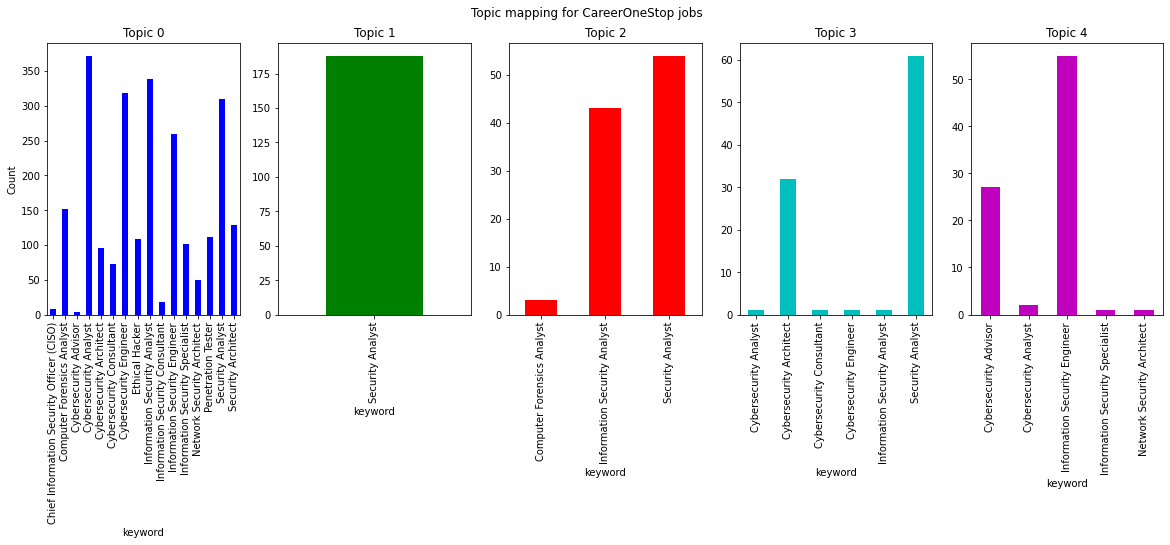

In [76]:
#Barplots showing the job families for each topic
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))

# plot each series on a different subplot
topic_0.plot.bar(ax=axs[0], color='b')
topic_1.plot.bar(ax=axs[1], color='g')
topic_2.plot.bar(ax=axs[2], color='r')
topic_3.plot.bar(ax=axs[3], color='c')
topic_4.plot.bar(ax=axs[4], color='m')

# set titles and labels for each subplot
axs[0].set_title('Topic 0')
axs[1].set_title('Topic 1')
axs[2].set_title('Topic 2')
axs[3].set_title('Topic 3')
axs[4].set_title('Topic 4')
axs[0].set_ylabel('Count')


# set a title for the figure
fig.suptitle('Topic mapping for CareerOneStop jobs')

# display the plot
plt.show()